# Correlation plots for IPO/ENSO and GPCC precipitation

Figure S1: Correlations between Pacific SST modes and South American DJF precipitation from GPCC data (1890 – 2000 CE). Statistical significance at p<0.05 is indicated with black stippling.

# Preamble

In [19]:
# # ---------------------------- LIBRARIES
import numpy as np
import pandas as pd
import xarray as xr   # use xarray to open data files instead of netCDF4.  It is faster, and easier. And, it keeps my metadata!
import scipy.stats as stats
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import proplot as pplt

# ---------------------------- IGNORE PLOTTING WARNING
import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

# %matplotlib inline   # This works in jupyter notebooks, otherwise I can't use it. Also, I would need plt.show()

# ---------------------------- Add t-test function for smoothed dataset with reduced degrees of freedom.
#statistical significance for smoothed data, decreased degrees of freedom. Henry He
def t_p_test(x1, x2, lpp): 
    """
    calculate statistical significance of correlation using adjusted degrees of freedom for smoothed data
    also calculates the p value for tx1: population sample. 
    More info on calculating the pvalue with adjusted degrees of freedom here: https://docs.scipy.org/doc/scipy/tutorial/stats.html
    x2: population sample
    x3: number of smoothing units
    llp: number of years in the smoothing. 
    returns: t statistic and the p value
    """
    n = x1.shape[0]                      # ipo_index_had.shape = 130
    df = 2*n/lpp - 2                     # 2*130 / 11 - 2 = 28.889
#     nas = np.isnan(x2)
#     r = stats.pearsonr(x1[~nas], x2[~nas])[0]        # need same shape: pearsonr(ipo_index_had, var[:,0,1])[0]
    r = stats.pearsonr(x1, x2)[0]        # need same shape: pearsonr(ipo_index_had, var[:,0,1])[0]
    error = np.sqrt((1 - r**2) / df)     # sqrt needs np.
    t = r/error                          # float value
    p = stats.t.sf(np.abs(t), df)*2      # calculate p value
    return r, p

# IPO

## Load parameters, process

In [4]:
# Load precip data: 
# GPCC
gpcc_pth = "/network/rit/home/ro553136/orrison/data/observations/GPCC/"
gpcc_f = "DJF_v2018_05_seassum.nc"
fh_gpcc = xr.open_dataset(gpcc_pth + gpcc_f)
fh_gpcc['lon'] = 360 + fh_gpcc.lon
gpcc_pr = fh_gpcc.precip[:110].load()
gpcc_pr = gpcc_pr.sel(lat=slice(15,-50),lon=slice(275,325))

gpcc_pr['time'] = np.arange(1890,2000)
yrs = gpcc_pr.time
gpcc_lat = gpcc_pr.lat
gpcc_lon = gpcc_pr.lon

In [6]:
# -------------- FOR GPCC Precipitation
# -------------- DETREND, SAVE AS XR, APPLY 11 YR SMOOTHING
# detrend data, save as xr, smooth
vars_all_11yr = []
vars_all_dt = []
vari_dt = np.zeros(gpcc_pr.shape)
for i in range(len(gpcc_lat)):
    for j in range(len(gpcc_lon)):
        var_tmp = gpcc_pr[:,i,j]#.astype(float)
        nas = np.isnan(gpcc_pr[:,i,j])
        if not sum(nas) == 110:
            m, b, r_val, p_val, std_err = stats.linregress(gpcc_pr[:,i,j][~nas].time,gpcc_pr[:,i,j][~nas])
            x = gpcc_pr[:,i,j][~nas].time
            trend_line = m*x+b
            vari_detrended = gpcc_pr[:,i,j][~nas] - trend_line
            vari_dt[:,i,j] = vari_detrended.reindex(time=yrs,fill_value=np.nan)
        else: vari_dt[:,i,j] == gpcc_pr[:,i,j]
        
#------------------- format as an xr Data Array -------------------
var = xr.DataArray(vari_dt, 
    coords={'time': yrs,'latitude': gpcc_lat,'longitude': gpcc_lon}, 
    dims=["time","lat", "lon"], name = 'GPCC Prect')     
#------------------- set up for smoothing -------------------
var_11yr = xr.DataArray(np.zeros([len(yrs), len(gpcc_lat), len(gpcc_lon)]), 
    coords={'time': yrs,'latitude': gpcc_lat,'longitude': gpcc_lon}, 
    dims=["time","lat", "lon"], name = 'GPCC Prect')   
        
#------------------- 11 year smoothing to match TPI -------------------
nt = len(var.time)
filter_11yr = 11
mirror = int((filter_11yr-1)/2) # end point
copy = np.zeros((nt+2*mirror))
for i in range(len(gpcc_lat)):
    for j in range(len(gpcc_lon)):
        copy[mirror:-mirror] = var[:,i,j].copy()
        copy[0:mirror] = var[1:mirror+1,i,j].copy()[::-1]
        copy[-mirror:] = var[-1-mirror:-1,i,j].copy()[::-1]
        avg_mask_11yr = np.ones(filter_11yr) / np.real(filter_11yr)
        var_11yr[:,i,j] = np.convolve(copy, avg_mask_11yr, 'same')[mirror:-mirror]
vars_all_dt.append(var)
vars_all_11yr.append(var_11yr)

## Load IPO, ENSO indices


In [8]:
#------------------- IPO -------------------
pth_hadsst = '/network/rit/home/ro553136/orrison/data/reconstructions/sstforc_Had_OI/'
fh_hadipo = xr.open_dataset(pth_hadsst + 'HADSSTOI_ipoinds_1880_2000.nc', decode_times= True)
ipo_index_had = fh_hadipo.tpi_index_11yr

#------------------- ENSO -------------------
pth_had = '/network/rit/home/ro553136/orrison/data/reconstructions/sstforc_Had_OI/'
fh_ens = xr.open_dataset(pth_had + "HADOISST_N34_dt_1880_2000.nc")
n34ind_had = fh_ens.n34ind_had

icam_yrs = np.arange(1880,2000)

#------------------- Capture only the djf season -------------------
n34ind_djf_had = [np.nanmean(n34ind_had[11+i:14+i],axis=0) for i in range(0,1440,12)]
n34ind_djf_had_xr = xr.DataArray(n34ind_djf_had, 
    coords={'time': icam_yrs}, 
    dims=["time"])

# Correlations (TPI/ENSO, gpcc across domain)

In [13]:
gpcc_f_r_ipo, gpcc_f_p_ipo = (xr.DataArray(np.zeros([len(gpcc_lat), len(gpcc_lon)]), coords={"latitude":gpcc_lat,"longitude":gpcc_lon}, dims=["lat","lon"],name='gpcc prect')), (xr.DataArray(np.zeros([len(gpcc_lat), len(gpcc_lon)]), coords={"lat":gpcc_lat,"lon":gpcc_lon}, dims=["lat","lon"],name='gpcc prect')) 

for x in range(len(gpcc_lat)):
    for y in range(len(gpcc_lon)):
#         nas = np.isnan(vars_all_11yr[3][:,x,y])          
        gpcc_f_r_ipo[x,y] = t_p_test(ipo_index_had.sel(time=yrs),vars_all_11yr[0][:,x,y],11)[0]
        gpcc_f_p_ipo[x,y] = t_p_test(ipo_index_had.sel(time=yrs),vars_all_11yr[0][:,x,y],11)[1]
    
gpcc_f_r_enso, gpcc_f_p_enso = (xr.DataArray(np.zeros([len(gpcc_lat), len(gpcc_lon)]), coords={"latitude":gpcc_lat,"longitude":gpcc_lon}, dims=["lat","lon"],name='gpcc prect')), (xr.DataArray(np.zeros([len(gpcc_lat), len(gpcc_lon)]), coords={"lat":gpcc_lat,"lon":gpcc_lon}, dims=["lat","lon"],name='gpcc prect')) 
for x in range(len(gpcc_lat)):
    for y in range(len(gpcc_lon)):
        gpcc_f_r_enso[x,y] = pearsonr(n34ind_djf_had_xr.sel(time=yrs),vars_all_dt[0][:,x,y])[0]
        gpcc_f_p_enso[x,y] = pearsonr(n34ind_djf_had_xr.sel(time=yrs),vars_all_dt[0][:,x,y])[1]

/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  wa

In [14]:
# Gridded GPCC stat sig
# create hatching for stippling over statistical significance
    # IPO
gpcc_hatch_ipo = []
[m,n] = np.where(gpcc_f_p_ipo < 0.05)
hatch=np.zeros(gpcc_f_r_ipo.shape)
hatch[m, n] = 1
gpcc_hatch_ipo.append(hatch)

    # ENSO
gpcc_hatch_enso = []
[m,n] = np.where(gpcc_f_p_enso < 0.05)
hatch=np.zeros(gpcc_f_r_enso.shape)
hatch[m, n] = 1
gpcc_hatch_enso.append(hatch)

# plotting fully gridded precipitation (GPCC)

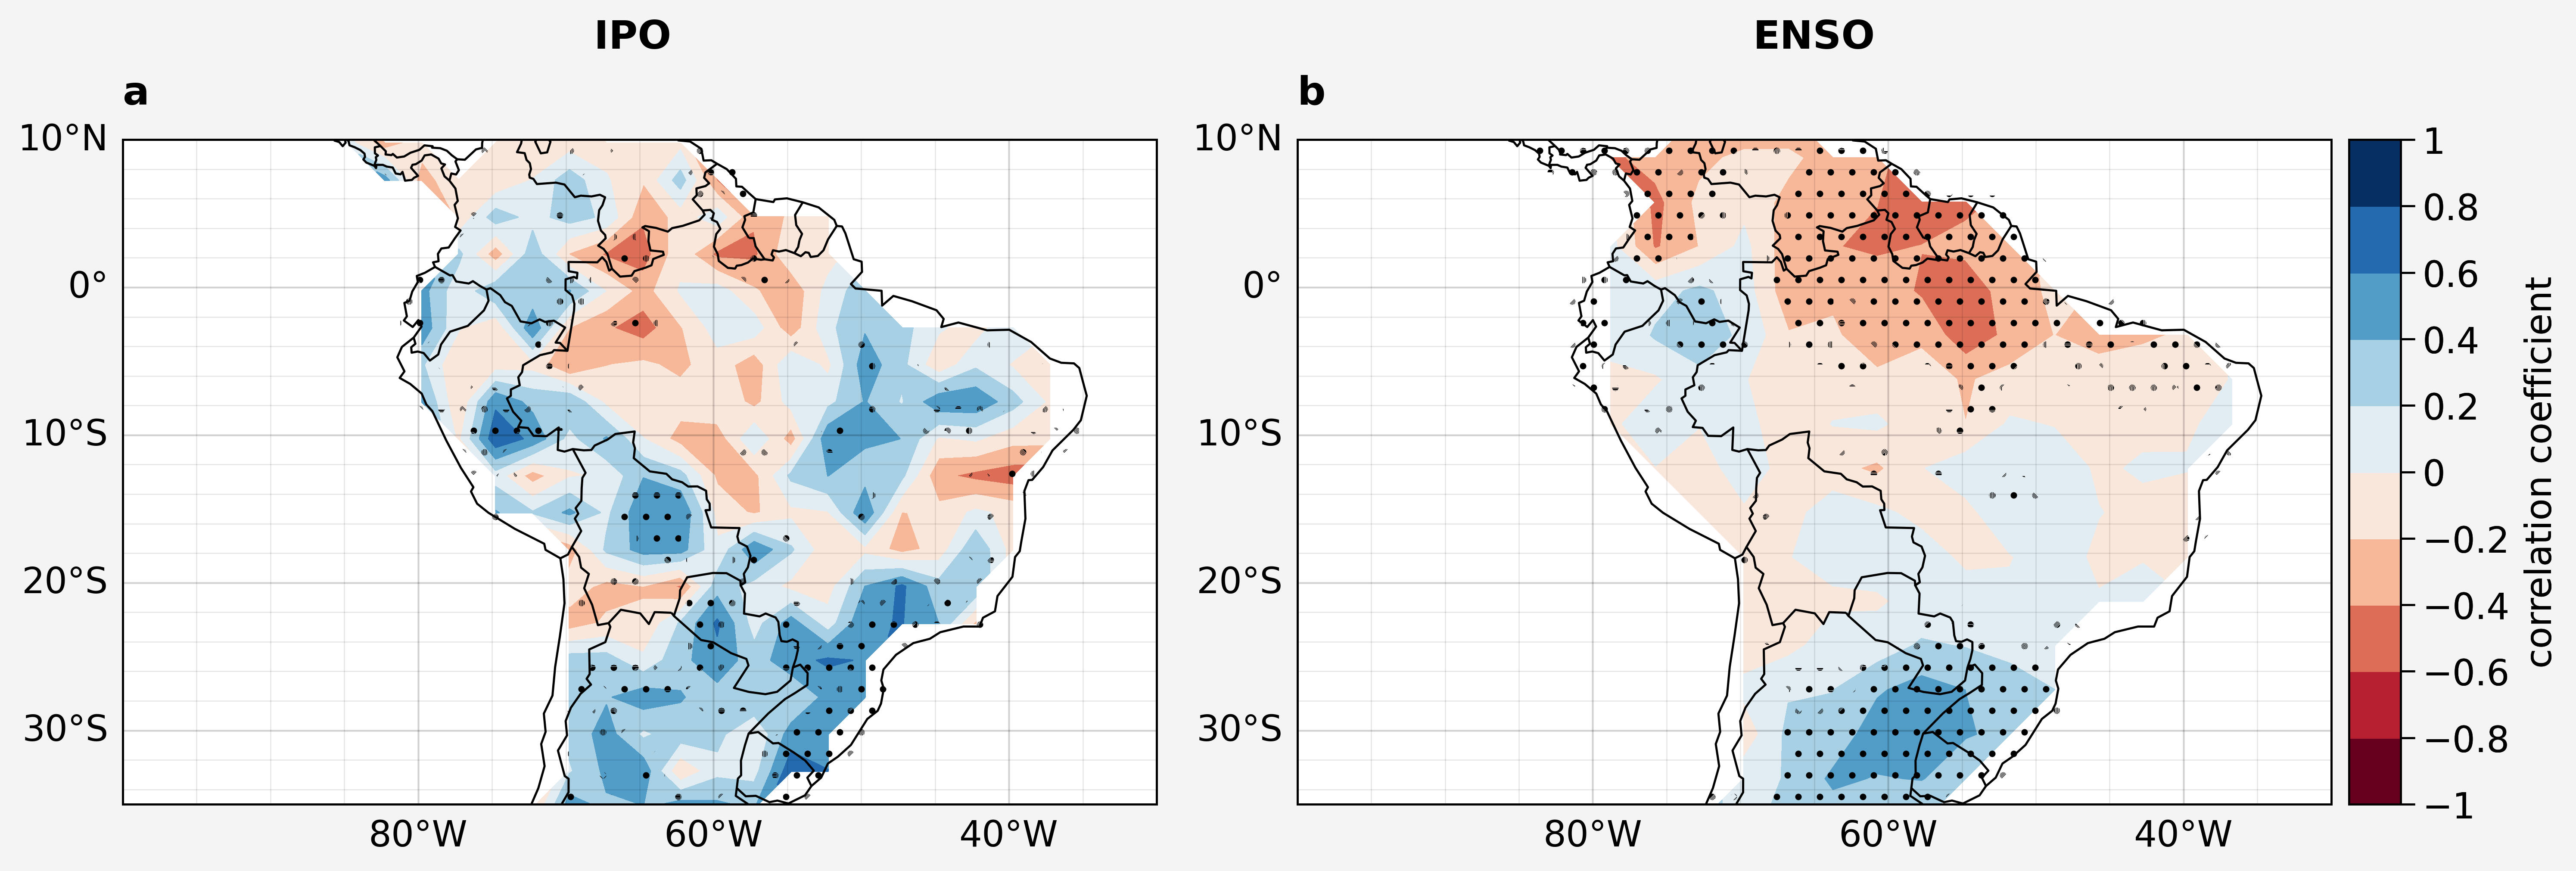

In [22]:
# ------
# Set up plotting framework: 
# ------     
fig, axs = pplt.subplots(ncols=2, nrows=1, axwidth=4, share=3, proj='cyl', dpi=300)
# fig, axs = pplt.subplots(nrows=1, ncols=1, proj=('cyl'),figsize=(8,5), dpi=300)

axs.format(land=False, labels=False, lonlines=20, latlines=10, coast=True, borders = True,
           gridminor=True, abc='a', abcloc='l',
           collabels=['IPO ','ENSO'],
           rowlabels=[''],
)
axs.format(lonlim=(260,330), latlim=(-35,10), labels=True)

# -------------------------- PLOTTING -------------------------- 

levs = np.arange(-1.0,1.1,0.2)
skip_i = 5 #IPO: doesn't work: 4
skip_e = 6 #ENSO: doesn't work: 2, 3, 5, 10, 20 #works: 4

# -------------------------- IPO
im = axs[0].contourf(gpcc_lon[::skip_i], gpcc_lat[::skip_i], gpcc_f_r_ipo[::skip_i,::skip_i],levels=levs,cmap='RdBu')
hatch = axs[0].contourf(gpcc_lon,gpcc_lat,gpcc_hatch_ipo[0], hatches=['', '..'],alpha=0.0)

# -------------------------- ENSO
im = axs[1].contourf(gpcc_lon[::skip_e], gpcc_lat[::skip_e], gpcc_f_r_enso[::skip_e,::skip_e],levels=levs,cmap='RdBu')
hatch = axs[1].contourf(gpcc_lon,gpcc_lat,gpcc_hatch_enso[0], hatches=['', '..'],alpha=0.0)

# -------------------------- Add colorbar
axs[1].colorbar(im, loc='r', label='correlation coefficient', tickloc='right',length=1.0)
    
# # -------------------------- Add patches for highlighting regions used in Figure 5 correlation analysis.
# p_rec = axs[0].add_patch(patches.Rectangle(xy=[285, -15], width=15, height=15,
#                                 facecolor='none', linestyle = 'dashed', edgecolor='k', lw=2., 
#                                 transform=ccrs.PlateCarree()))
# p_rec = axs[1].add_patch(patches.Rectangle(xy=[285, -15], width=15, height=15,
#                                 facecolor='none', linestyle = 'dashed', edgecolor='k', lw=2., 
#                                 transform=ccrs.PlateCarree()))

plt.savefig('/network/rit/lab/vuillelab_rit/orrison/Plots/Pac_SAm/r2r/FigS1_IPO_ENSOdt_precip_gpcc_corr_nobox_supp.jpg', format='JPEG',dpi=300)
plt.show()
